## Imports

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from sklearn.mixture import GaussianMixture

print("Packages Imported!")

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Packages Imported!


## Settings

In [2]:
# MANIFEST_PATH = "E:/datasets/allen_vc/manifest_files/manifest.json"
MANIFEST_PATH = "D:/datasets/allen_vc/manifest.json"
PROJECT_PATH = "G:/Shared drives/visual_encoding"
# REPO_PATH = 'C:/Users/User/visual_encoding'
REPO_PATH = 'C:/Users/micha/projects/visual_encoding'
DATA_PATH = "G:/Shared drives/visual_encoding/data/optotagging_data/concat"

## Functions

In [45]:
def plot_clustering_results(X, gm, idx_plt=[0,1]):
    feats = X.columns.to_list()
    preds = gm.predict(X) 
    _, ax = plt.subplots(figsize=(10,10))
    ax.scatter(X[feats[idx_plt[0]]], X[feats[idx_plt[1]]], c=preds, s=10, cmap='viridis')
    for ii in range(gm.n_components):
        plt.scatter(gm.means_[ii, idx_plt[0]], gm.means_[ii, idx_plt[1]], color='r', s=100)
    ax.set(xlabel=feats[idx_plt[0]].replace('_',' '), ylabel=feats[idx_plt[1]].replace('_',' '))
    plt.show()


## Load Data

In [4]:
# load optotagging response data

# load waveform data

# concatenate and train model!

In [5]:
# # Create Allensdk cache object
# cache = EcephysProjectCache.from_warehouse(manifest=MANIFEST_PATH)

# # Isolate functional connectivity sections
# sessions = cache.get_session_table()
# functional_connectivity_sessions = sessions[sessions['session_type'] == 'functional_connectivity']

In [46]:
# load optotagging response data
opto_df = pd.read_csv(f'{DATA_PATH}/all_stimuli_rr.csv')
print(opto_df['opto_stimulus'].unique())
opto_df.head()

['fast_pulses_1.0s_1' 'fast_pulses_1.0s_2' 'fast_pulses_1.0s_3'
 'pulse_0.0049999999991996455s_1' 'pulse_0.0049999999991996455s_2'
 'pulse_0.0049999999991996455s_3' 'pulse_0.01000000000021828s_1'
 'pulse_0.01000000000021828s_2' 'pulse_0.01000000000021828s_3'
 'raised_cosine_1.0s_1' 'raised_cosine_1.0s_2' 'raised_cosine_1.0s_3']


,unit_id,ecephys_structure_acronym,genotype,opto_stimulus,response_reliability
0,950922446,VISp,wt/wt,fast_pulses_1.0s_1,0.533333
1,950922495,VISp,wt/wt,fast_pulses_1.0s_1,0.133333
2,950922511,VISp,wt/wt,fast_pulses_1.0s_1,0.200000
3,950922546,VISp,wt/wt,fast_pulses_1.0s_1,0.133333
4,950922579,VISp,wt/wt,fast_pulses_1.0s_1,0.200000


In [8]:
# load spike waveform data
all_unit_waveforms_df = pd.read_csv('G:/Shared drives/visual_encoding/data/waveforms/all_units.csv')
all_unit_waveforms_df

,unit_id,waveform_repolarization_slope,waveform_velocity_above,waveform_duration,waveform_velocity_below,waveform_halfwidth,waveform_spread,waveform_recovery_slope,waveform_amplitude,session_id
0,950911624,0.666637,0.412060,0.247236,0.000000,0.137353,60.0,-0.115895,156.949650,766640955
1,950911641,0.494906,-0.343384,0.219765,0.068677,0.109883,60.0,-0.085105,144.387750,766640955
2,950911686,0.554810,0.686767,0.247236,0.000000,0.109883,30.0,-0.080528,132.559830,766640955
3,950911657,0.454659,0.343384,0.412060,0.068677,0.137353,70.0,-0.060789,108.663750,766640955
4,950911696,0.779000,0.000000,0.178559,-0.608279,0.123618,100.0,-0.220320,186.913740,766640955
...,...,...,...,...,...,...,...,...,...,...
18163,951190560,0.488657,0.000000,0.206030,0.147164,0.137353,100.0,-0.107414,112.009560,847657808
18164,951190571,0.225447,0.824121,0.782915,-0.304140,0.219765,100.0,-0.029030,109.269615,847657808
18165,951190848,0.378583,0.892797,0.673032,-0.206030,0.206030,80.0,-0.052196,124.145190,847657808
18166,951190594,0.343781,1.030151,0.700503,-0.137353,0.219765,80.0,-0.061936,140.108085,847657808


In [9]:
# merge datasets

stim = 'pulse_0.01000000000021828s_3'
waveform_features = ['waveform_repolarization_slope',
       'waveform_velocity_above', 'waveform_duration',
       'waveform_velocity_below', 'waveform_halfwidth', 'waveform_spread',
       'waveform_recovery_slope', 'waveform_amplitude']
stim_df = opto_df[opto_df['opto_stimulus'] == stim].copy()
wv_df = all_unit_waveforms_df.copy()

# join dfs on units
rwv_df = stim_df.merge(wv_df, how='inner', on='unit_id')

print(f"Shape\t{rwv_df.shape}")
rwv_df

Shape	(1679, 14)


,unit_id,ecephys_structure_acronym,genotype,opto_stimulus,response_reliability,waveform_repolarization_slope,waveform_velocity_above,waveform_duration,waveform_velocity_below,waveform_halfwidth,waveform_spread,waveform_recovery_slope,waveform_amplitude,session_id
0,950922446,VISp,wt/wt,pulse_0.01000000000021828s_3,0.133333,0.196397,1.648241,0.837856,0.000000,0.233501,70.0,-0.017755,82.695990,771160300
1,950922495,VISp,wt/wt,pulse_0.01000000000021828s_3,0.000000,0.189410,0.206030,0.865327,-0.343384,0.247236,60.0,-0.015247,75.754965,771160300
2,950922511,VISp,wt/wt,pulse_0.01000000000021828s_3,0.000000,0.196521,0.892797,0.975209,-1.030151,0.219765,60.0,-0.005732,101.102820,771160300
3,950922546,VISp,wt/wt,pulse_0.01000000000021828s_3,0.000000,0.337895,0.343384,0.782915,0.274707,0.192295,60.0,-0.020037,123.288945,771160300
4,950922579,VISp,wt/wt,pulse_0.01000000000021828s_3,0.000000,0.335487,2.541039,0.618090,0.343384,0.219765,60.0,-0.069469,126.942465,771160300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,951187345,VISp,wt/wt,pulse_0.01000000000021828s_3,0.120000,0.224074,0.000000,0.192295,-0.343384,0.068677,50.0,-0.068635,66.686880,847657808
1675,951187357,VISp,wt/wt,pulse_0.01000000000021828s_3,0.000000,0.240237,0.686767,0.755444,-0.824121,0.260972,80.0,-0.050865,129.761775,847657808
1676,951187369,VISp,wt/wt,pulse_0.01000000000021828s_3,0.160000,0.276874,0.824121,0.233501,0.000000,0.123618,70.0,-0.061505,62.602020,847657808
1677,951187421,VISp,wt/wt,pulse_0.01000000000021828s_3,0.000000,0.302307,1.304858,0.590620,-0.068677,0.219765,80.0,-0.056123,114.561720,847657808


In [10]:
# check for NaN
rwv_df.isna().sum()

unit_id                           0
ecephys_structure_acronym         0
genotype                          0
opto_stimulus                     0
response_reliability              0
waveform_repolarization_slope     0
waveform_velocity_above          26
waveform_duration                 0
waveform_velocity_below          38
waveform_halfwidth               13
waveform_spread                   0
waveform_recovery_slope           8
waveform_amplitude                0
session_id                        0
dtype: int64

In [11]:
# drop nan
rwv_df.dropna(inplace=True)
print(rwv_df.shape)

(1598, 14)


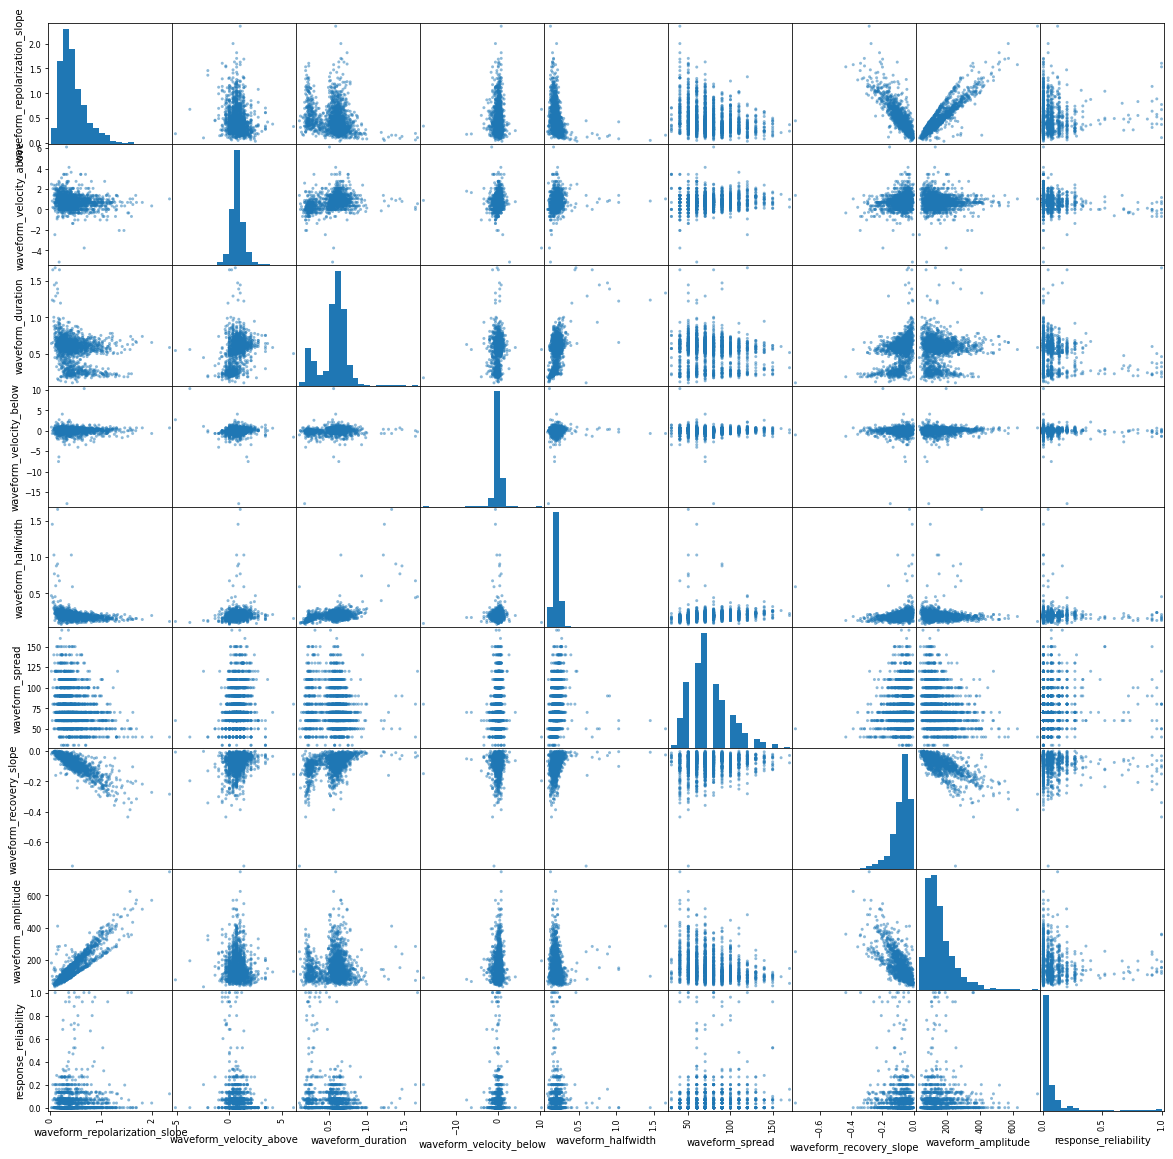

In [12]:
# plot scatter matrix
pd.plotting.scatter_matrix(rwv_df[waveform_features + ['response_reliability']], figsize=(20,20), hist_kwds={'bins':20});

In [13]:
# save to csv
# rwv_df.to_csv(f'G:/Shared drives/visual_encoding/data/optotagging_data/concat/rr_wave_{stim}.csv', index=False)

# Clustering

In [33]:
# settings
clust_set = {'n_components': 2, 'random_state': 0, 'verbose': 1}

In [34]:
# initiailize model
gm = GaussianMixture(**clust_set)

In [42]:
# fit GMM

# pick features
# feats = ['waveform_duration', 'waveform_amplitude']
feats = waveform_features.copy()

# fit model
X = rwv_df[feats] # choose two metrics for visualization
gm.fit(X)
preds = gm.predict(X)

# print results
print(f"\nBaysian Information Criterion: {gm.bic(X)}")
print(f"\nMeans:\n{gm.means_}")
gm

Initialization 0
Initialization converged: True

Baysian Information Criterion: 21144.155561101383

Means:
[[ 3.96186674e-01  8.10993390e-01  5.81577522e-01 -1.14341318e-02
   1.94044290e-01  7.69536126e+01 -6.61981094e-02  1.33254295e+02]
 [ 8.18593408e-01  5.00678298e-01  4.85939921e-01 -3.14316662e-02
   2.03259495e-01  6.60490040e+01 -1.56430016e-01  2.50783658e+02]]


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=1,
                verbose_interval=10, warm_start=False, weights_init=None)

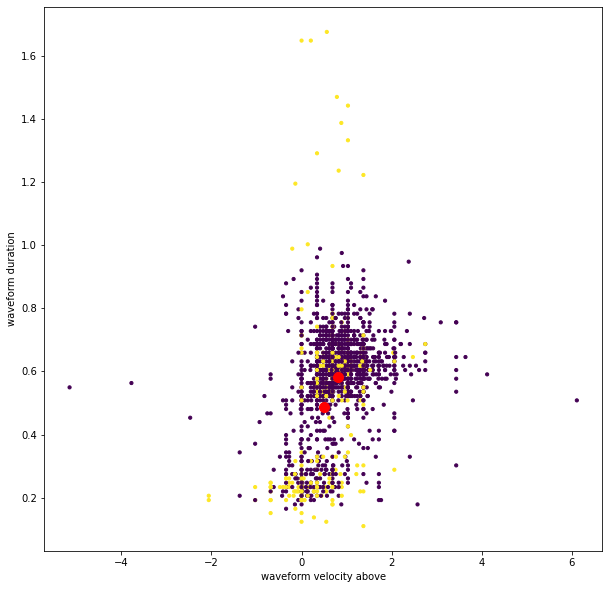

In [47]:
# plot clustering results
plot_clustering_results(X, gm, idx_plt=[1,2])

In [22]:
# plot rr for both groups?

In [23]:
# fit number of components to all data
max_comp = 15
X = rwv_df[waveform_features]
clust_set['verbose'] = False

bics = []
for i in range(1, max_comp):
    
    clust_set['n_components'] = i
    gm = GaussianMixture(**clust_set)
    gm.fit(X)
    
    bics.append(gm.bic(X))

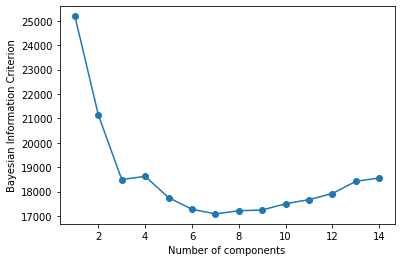

In [24]:
# plot BIC v # components
n_comp = range(1, max_comp)

plt.plot(n_comp, bics)
plt.scatter(n_comp, bics)

plt.xlabel('Number of components')
plt.ylabel('Bayesian Information Criterion');

In [25]:
# find minimum
n_comp = range(1, max_comp)
min_bic = n_comp[np.argmin(bics)]
print(f"Number of components with minimum BIC: {min_bic}")

Number of components with minimum BIC: 7


Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


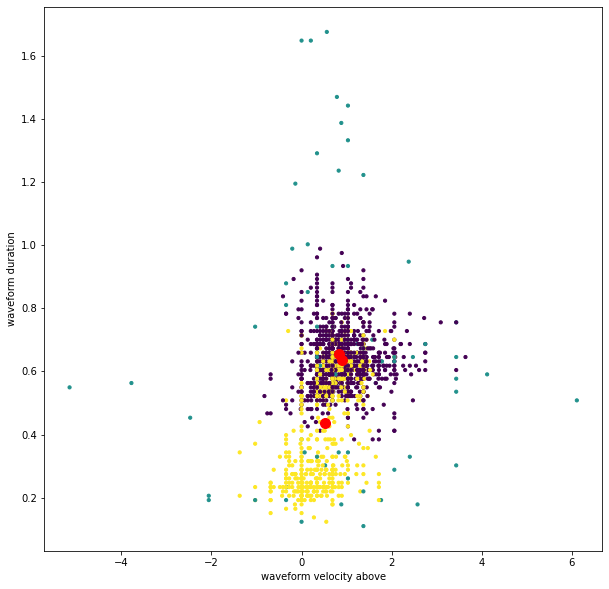

In [50]:
# fit with min_bic components
clust_set['n_components'] = 3 # min_bic
gm = GaussianMixture(**clust_set)
gm.fit(X)
plot_clustering_results(X, gm, idx_plt=[1,2])